In [1]:
import torch
from torchvision import datasets

In [2]:
download_dir = "./dataset"

# Скачиваем обучающую выборку.
train_data = datasets.SVHN(root=download_dir, download=True, split='train')

# Скачиваем валидационную выборку.
val_data = datasets.SVHN(root=download_dir, download=True, split='test')

Using downloaded and verified file: ./dataset/train_32x32.mat
Using downloaded and verified file: ./dataset/test_32x32.mat


In [3]:
# Объекты данных из обучающей выборки
x_train = torch.tensor(train_data.data)
x_train.shape

torch.Size([73257, 3, 32, 32])

In [4]:
# Предсказываемые величины для обучающей выборки (числа от 0 до 9).
y_train = torch.tensor(train_data.labels)

print(y_train.shape, y_train.min(), y_train.max(), sep="\n")


torch.Size([73257])
tensor(0)
tensor(9)


In [5]:
# В SVHN классы — это просто цифры от 0 до 9, поэтому список создается вручную
classes = [str(i) for i in range(10)]
print(classes)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
# Аналогично записываем x и y для валидационной выборки
x_val = torch.tensor(val_data.data)
y_val = torch.tensor(val_data.labels)

print(x_val.shape, y_val.shape, sep="\n")


torch.Size([26032, 3, 32, 32])
torch.Size([26032])


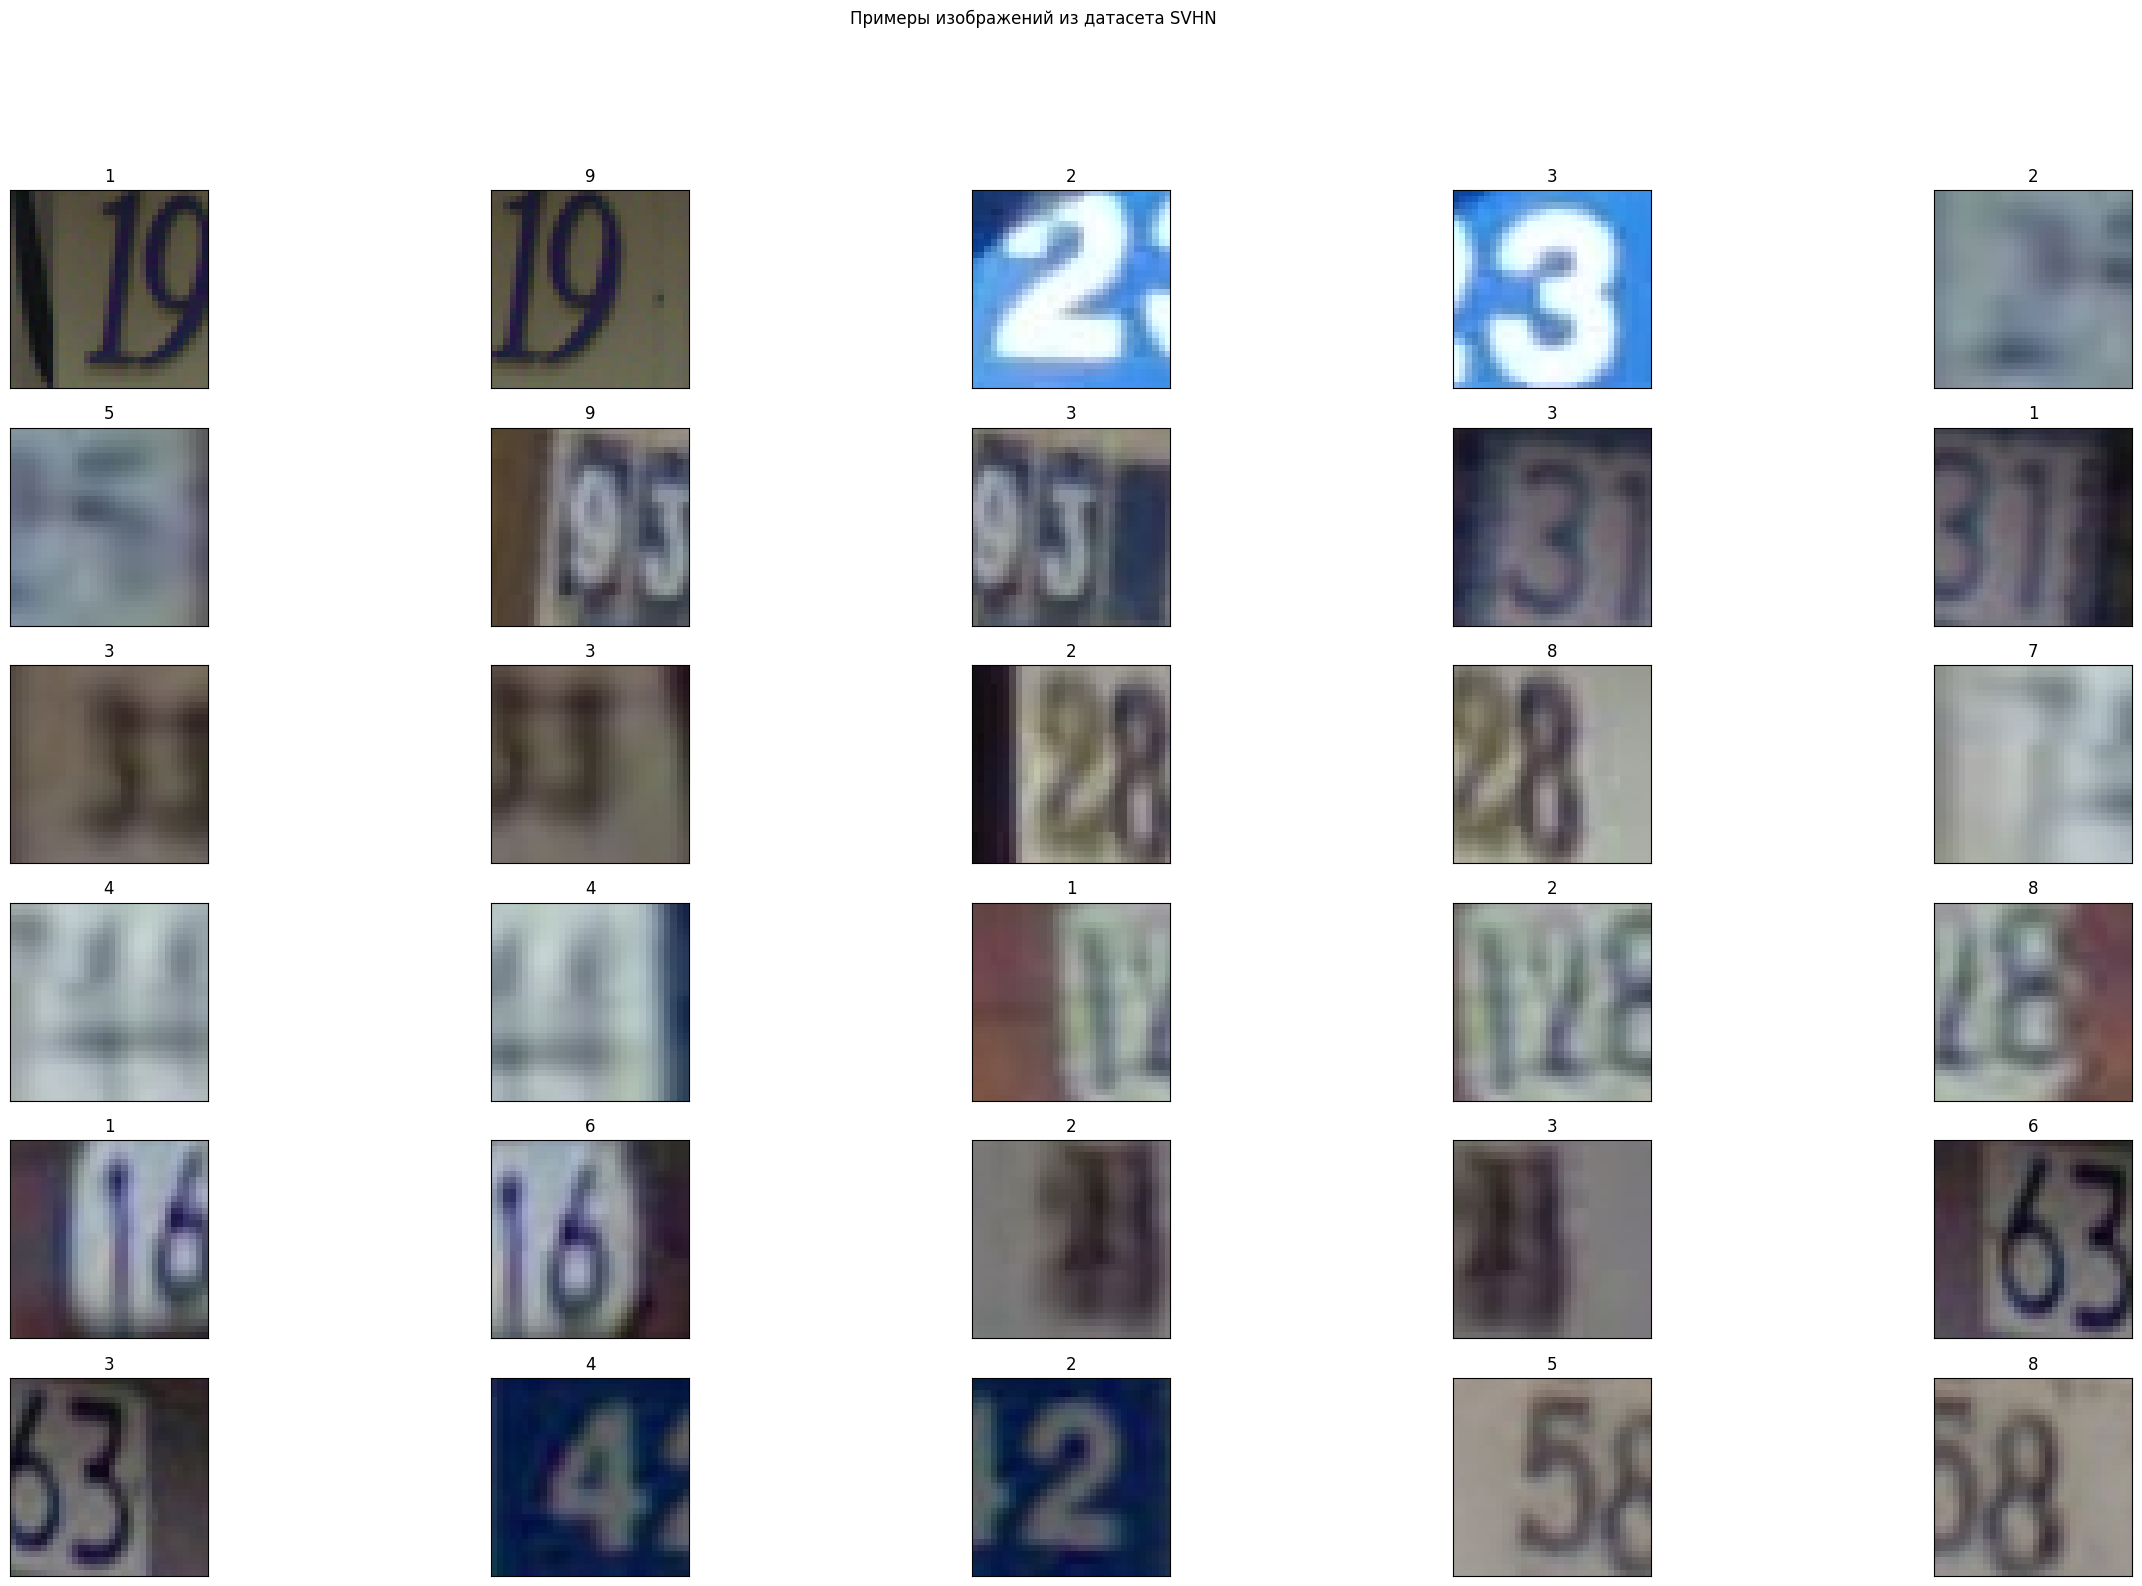

In [7]:
# Посмотрим на то, как выглядят картинки из датасета.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 6
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(30, 3 * hh))
fig.suptitle("Примеры изображений из датасета SVHN")

for i, (x, y) in enumerate(zip(x_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    img = x.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[y])
plt.show()

In [8]:
print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)
torch.uint8


In [9]:
# Преобразуем x_train в формат float32 и нормализуем значения
x_train = x_train.to(torch.float32) / 255.0

# Проверим новые параметры
print(x_train.min(), x_train.max(), x_train.dtype, sep="\n")


tensor(0.)
tensor(1.)
torch.float32


In [10]:
import torch

class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                   # Число каналов на входе.
        output_c,                  # Число каналов на выходе.
        kernel_size,               # Размер ядра.
        activation=torch.nn.LeakyReLU,  # Заменили на LeakyReLU
        padding_mode='zeros'       # Режим паддинга (по умолчанию - заполнение нулями).
    ):
        super().__init__()

        # Функция активации для нелинейности.
        self.activation = activation(negative_slope=0.01)  # Устанавливаем наклон отрицательной части

        # Паддинг подбираем такой, чтобы размеры h и w не менялись
        padding_size = kernel_size // 2

        # Операция свёртки.
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,
            out_channels=output_c,
            kernel_size=kernel_size,
            padding=padding_size,
            padding_mode=padding_mode
        )

        # Если числа каналов у входа и выхода различаются,
        if input_c != output_c:
            # То делаем свёртку с ядром размера 1 для изменения числа каналов.
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,
                out_channels=output_c,
                kernel_size=1,
                padding=0  # Ядро 1x1 не требует паддинга
            )
        else:
            self.correct_channels = torch.nn.Identity()  # Слой, никак не меняющий вход.

    # Прямой проход.
    def forward(self, x):
        # Прямой проход через свёртку и остаточную связь.
        return self.activation(self.conv(x) + self.correct_channels(x))


In [11]:
import torch

class LeNet5Residual(torch.nn.Module):
    def __init__(self):
        super(LeNet5Residual, self).__init__()

        # Первый ResidualBlock заменяет первую конволюцию
        self.res_block1 = ResidualBlock(input_c=3, output_c=32, kernel_size=5)
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        # Второй ResidualBlock заменяет вторую конволюцию
        self.res_block2 = ResidualBlock(input_c=32, output_c=64, kernel_size=5)
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = torch.nn.Flatten()

        # Полносвязные слои с LeakyReLU
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 120)
        self.act1 = torch.nn.LeakyReLU(negative_slope=0.01)  # Заменили на LeakyReLU

        self.fc2 = torch.nn.Linear(120, 84)
        self.act2 = torch.nn.LeakyReLU(negative_slope=0.01)  # Заменили на LeakyReLU

        self.fc3 = torch.nn.Linear(84, 10)  # 10 классов для SVHN

    def forward(self, x):
        x = self.res_block1(x)
        x = self.pool1(x)

        x = self.res_block2(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)

        return x

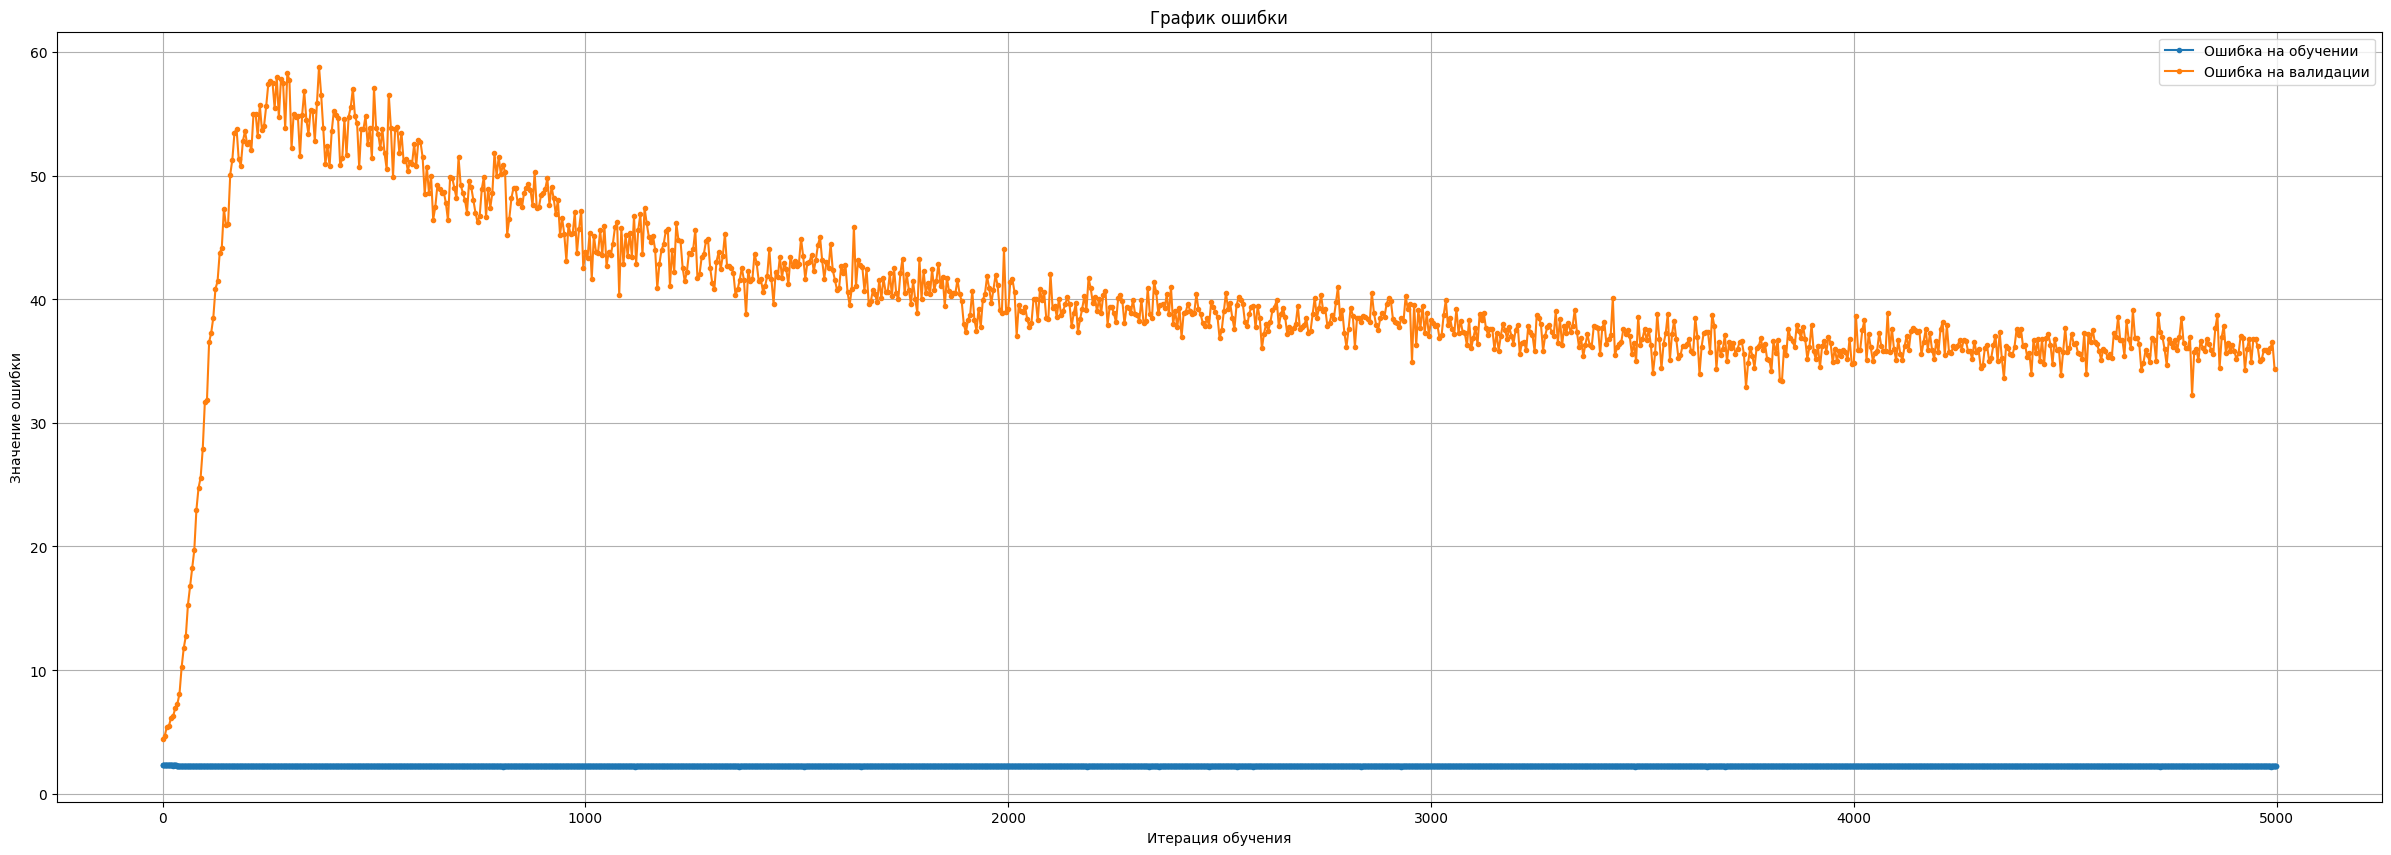

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = LeNet5Residual().to(dtype=torch.float32, device=device)  # Обратите внимание на dtype

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.CrossEntropyLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    # Случайный выбор батча
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])

    # Преобразуем данные в float и отправляем на устройство
    pred = model(x_train[batch_pos].to(device).float())
    loss = loss_fn(pred, y_train[batch_pos].to(device).long())

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Выводим текущее значение потерь на обучении
    print(f"Эпоха {epoch}: Потери на обучении = {loss.item()}")

    # Каждые val_every итераций считаем значение loss на валидационной выборке
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device).float())
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device).long())
            losses["val"].append(val_loss.item())

            # Выводим текущее значение потерь на валидации
            print(f"Эпоха {epoch}: Потери на валидации = {val_loss.item()}")

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

Я не смог разобраться, почему потери на обучении изменяются только на десятые или сотые доли, а потери на валидации имеют явное изменение

In [13]:
# Проверка размеров данных
print(f"Размер обучающей выборки: {x_train.shape}")
print(f"Размер валидационной выборки: {x_val.shape}")

Размер обучающей выборки: torch.Size([73257, 3, 32, 32])
Размер валидационной выборки: torch.Size([26032, 3, 32, 32])


In [14]:
import numpy as np

# Подсчет количества примеров для каждого класса
unique, counts = np.unique(y_train.numpy(), return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Распределение классов:", class_distribution)

Распределение классов: {0: 4948, 1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659}


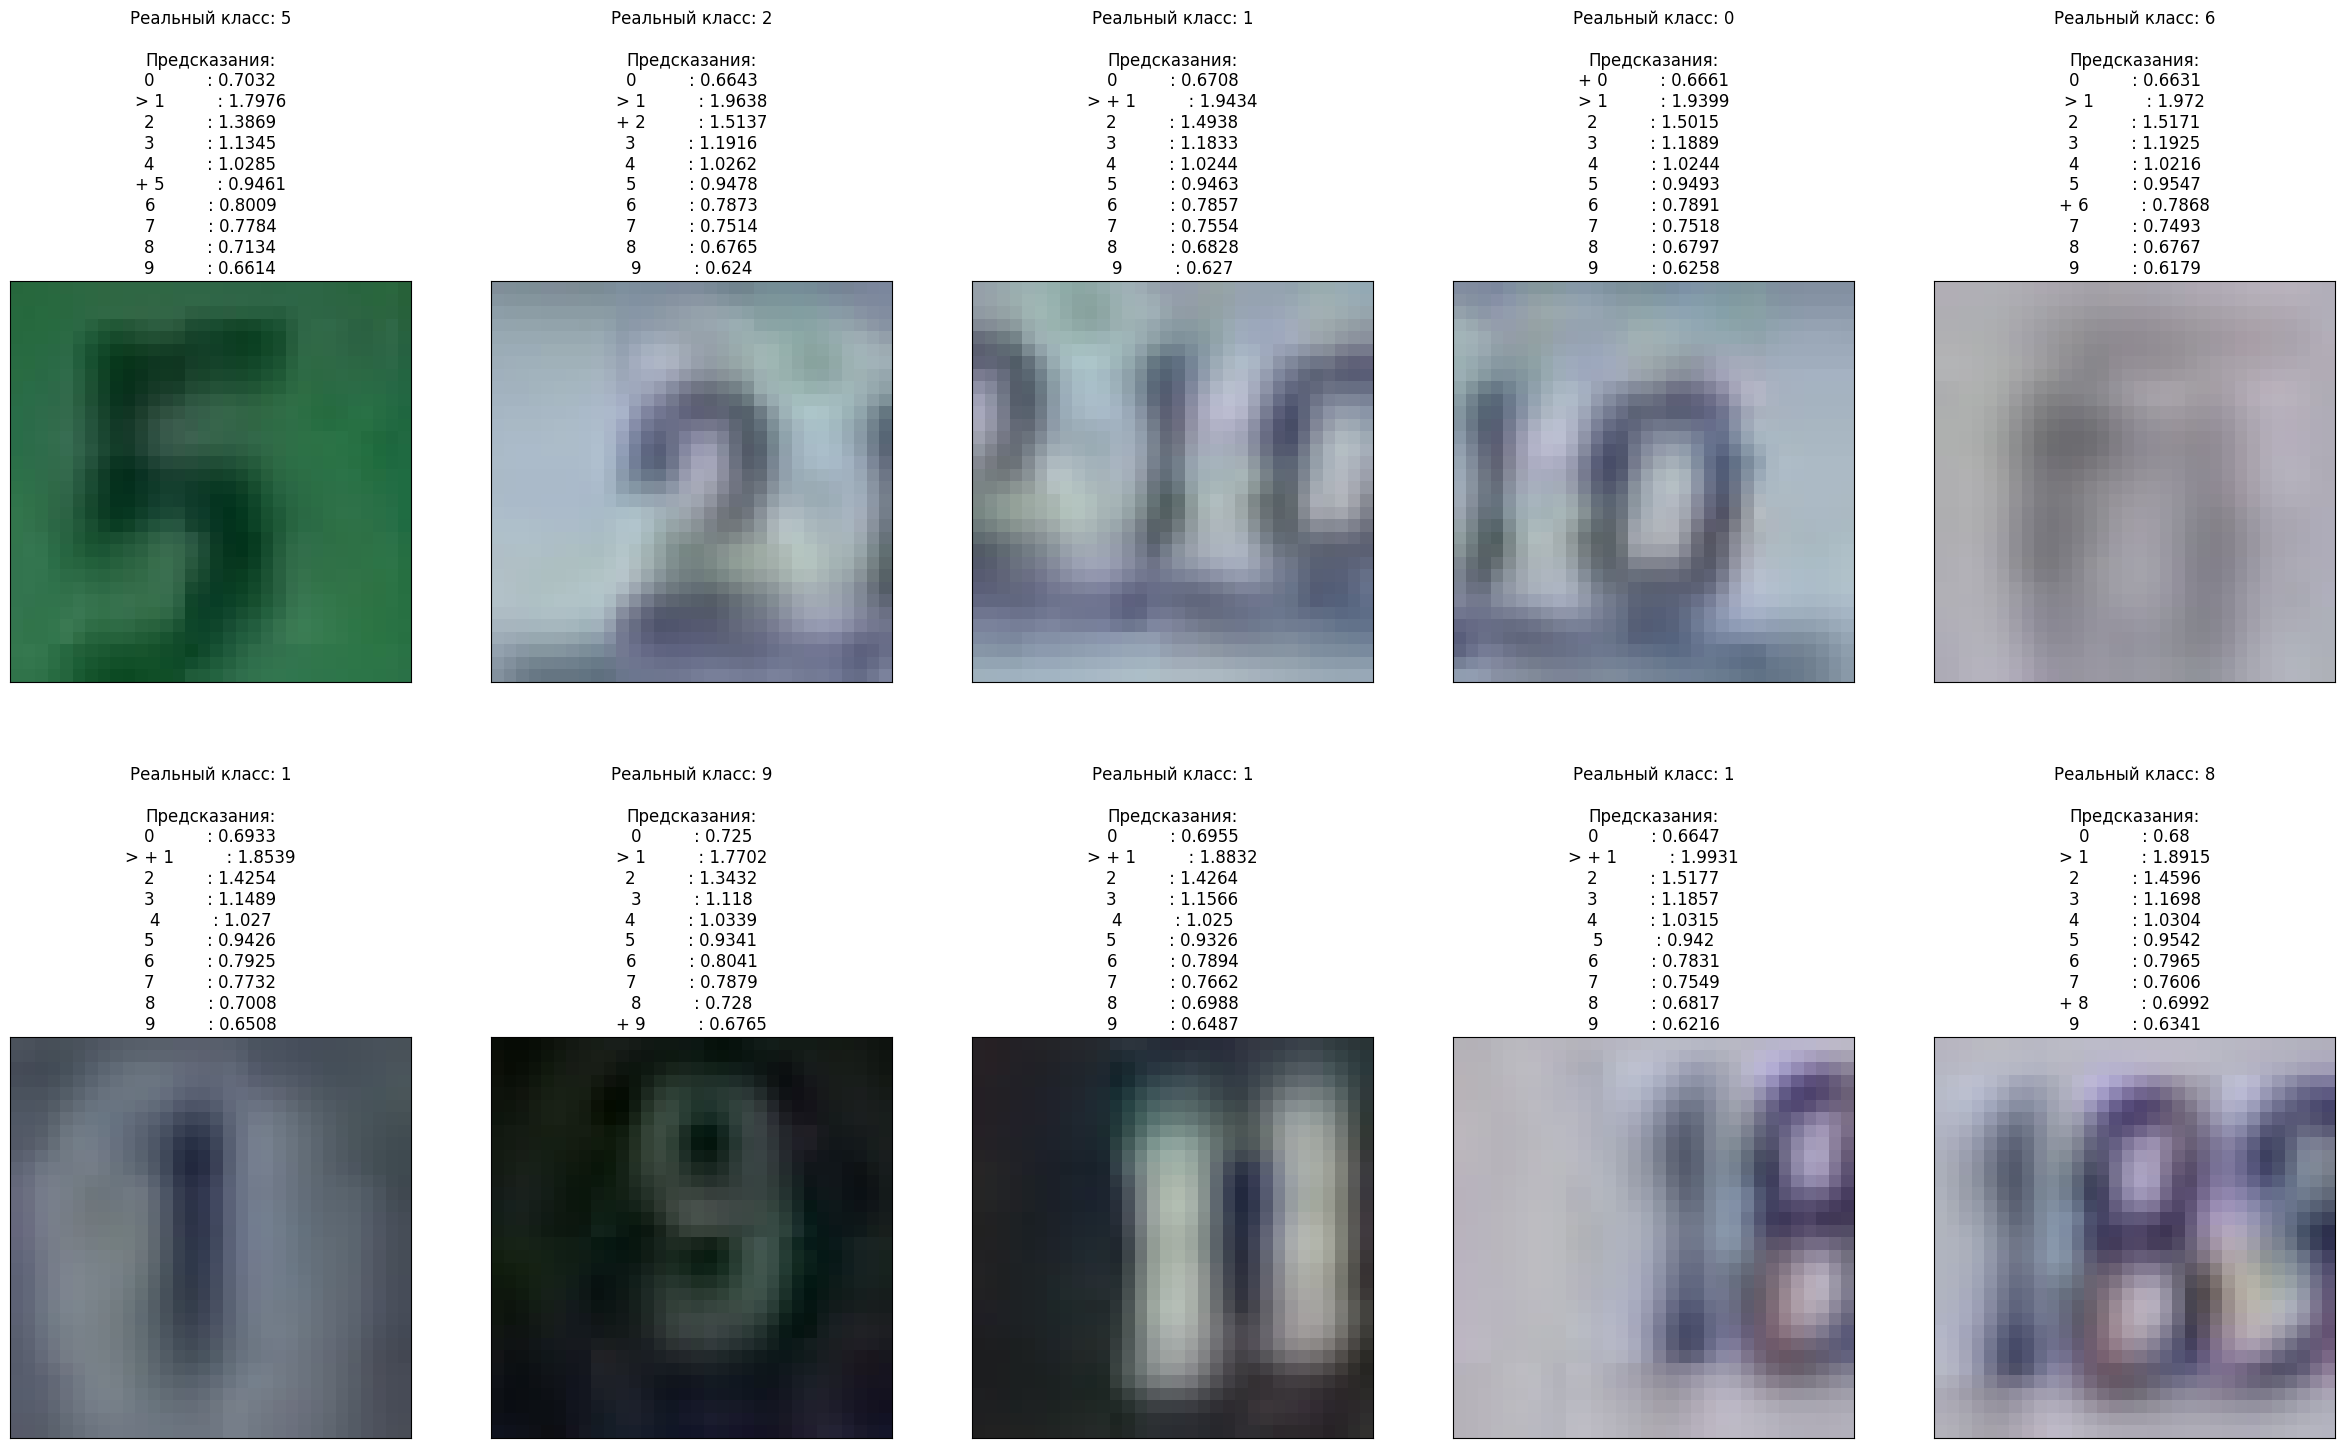

In [15]:
import matplotlib.pyplot as plt

# Классы для SVHN
classes = [str(i) for i in range(10)]

def show_results(model, h=2, w=5):
    with torch.no_grad():
        # Преобразуем входные данные в float и нормализуем
        batch_data = x_val[:h*w].to(device).float() / 255.0  # Преобразуем в float и нормализуем
        batch_probs = model(batch_data).exp()  # Получаем вероятности предсказаний

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i + 1)
            plt.imshow(x_val[i].permute(1, 2, 0))  # Изменяем порядок каналов для отображения
            title = f'Реальный класс: {classes[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])  # Получаем предсказанный класс
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])  # Убираем отметки по оси x
            plt.yticks([])  # Убираем отметки по оси y
        plt.show()

show_results(model)
